# EEG preprocessing 
### Effect of prediction and attention on C1 component
Written by Maximilien Van Migem
and Created on 22/11/2023 

Extracting EDF parameters from C:\Users\mvmigem\Documents\data\project_1\raw_data\sub_21\eeg\main_21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1541631  =      0.000 ...  3010.998 secs...
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'eye_above', 'eye_below', 'eye_left', 'eye_right', 'M1', 'M2', 'Status']
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 66 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2024-06-14 16:39:06 UTC
 n

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 85.33 Hz
- Upper transition bandwidth: 21.33 Hz (-6 dB cutoff frequency: 96.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
4277 events found
Event IDs: [   11    13    22    24    31    33    42    44    99   255 65536 65789
 65791]


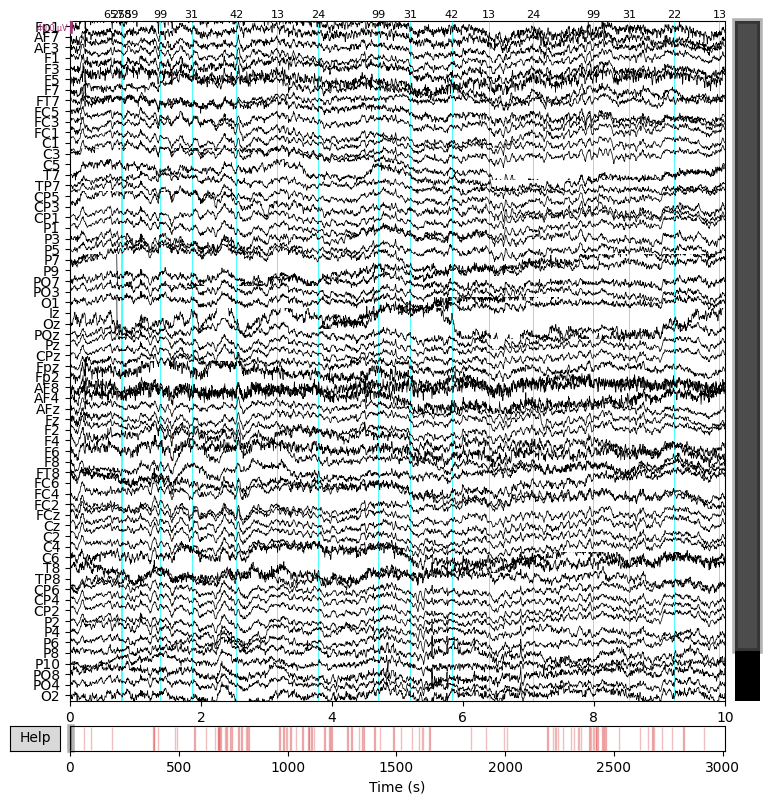

In [3]:
# Import some libraries
import os
import numpy as np
import mne
import pandas as pd

%matplotlib qt 

# Subject selection and loading data
sub = 21
# reference = 'average'
reference = ['M1','M2'] # Mastoids

data_directory = 'C:/Users/mvmigem/Documents/data/project_1/'
rejected_channels_path = data_directory + 'rejected_channels.npy'
rejected_ica_path = data_directory + 'mastoid_rejected_ica.npy'
# rejected_ica_path = data_directory + 'average_rejected_ica.npy'
current_file_path = data_directory + f'raw_data/sub_{sub}/eeg/main_{sub}.bdf'
current_behav_path = data_directory + f'raw_data/sub_{sub}/behav/predatt_participant_{sub}.csv'
behav_data = pd.read_csv(current_behav_path)

raw = mne.io.read_raw_bdf(current_file_path, preload = True)

# we rename the channels to their respective external electrodes
fix_chans = {'EXG1':'eye_above','EXG2':'eye_below',
             'EXG3':'eye_left','EXG4':'eye_right',
             'EXG5':'M1','EXG6':'M2'}
raw.rename_channels(fix_chans)

# we still have two exg channels which weren't actually recorded though (EXG7
# and EXG8) these are empty, so we'll drop them
raw.drop_channels(['EXG7', 'EXG8'])
print(raw.info['ch_names'])

# we'll also reset the channel types, so MNE knows what is 'brain' data
raw.set_channel_types({'M1':'eeg', 'M2':'eeg',
                       'eye_above':'eog', 'eye_below':'eog',
                       'eye_left':'eog', 'eye_right': 'eog'})

print(raw.info)

# # rereference to mastoids
# raw.set_eeg_reference(ref_channels = ['M1','M2'])

# rereference
raw.set_eeg_reference(ref_channels = reference)

raw.drop_channels(['M1','M2'])

## I'll drop the mastoids because I'm not using them
# raw.drop_channels(['mastoid_left', 'mastoid_right'])
# Set montage
montage = mne.channels.make_standard_montage('biosemi64')

# This dict is to rename the channel names to fit the montage
mon_chnames = montage.ch_names
raw_chnames = raw.info['ch_names']
rename_channels = dict(zip(raw_chnames[:64],mon_chnames))
raw.rename_channels(rename_channels)
# Set montage
raw.set_montage(montage)
# take another look
# raw.plot(n_channels = 64)

# we can annotate bad spans of raw data in the interactive plot by pressing the
# 'a' key, useful if we know there is a period we aren't interested in such
# as a mis-start of the task etc.
raw_annot = raw.copy()

# we can also identify eog events algorithmically via "find_eog_events" this
# produces a list of 'events' around each blink (hopefully). This applies a 
# filter and then identifies peaks in the eog to find likely blinks. We can 
# adjust the threshold, via thresh. but default should be okay for now.
eog_events = mne.preprocessing.find_eog_events(raw_annot)
# we'll say that the blinks start a tiny bit earlier than 
onsets = eog_events[:, 0] / raw_annot.info["sfreq"] - 0.25
# we'll assume they're all half a second long
dur = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(onsets,
                              dur,
                              descriptions,
                              orig_time = raw_annot.info["meas_date"])
raw_annot.set_annotations(blink_annot)

# let's take a look at what has been detected

# Downsampling variables (logic -> https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#best-practices)
current_sfreq = raw.info['sfreq']
desired_sfreq = 256  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.


raw_filtered = raw_annot.copy().notch_filter(freqs = 50, fir_design = 'firwin', verbose=None, )
raw_filtered = raw_filtered.copy().filter(l_freq=0.1, h_freq=lowpass_freq)


# # Plotting for potential channel rejection
# raw_filtered.plot_psd()
# raw_filtered.plot(n_channels=64)

# Load the rejected channel
rejected_channels = np.load(rejected_channels_path, allow_pickle=True)[..., np.newaxis][0]
raw_filtered.info['bads'] = rejected_channels[f'subject_{sub}']
# np.save(rejected_channels_path, rejected_channels)
# Interpolate rejected channels
interp_filt_raw = raw_filtered.copy().interpolate_bads(reset_bads = True)

# Select event dict for condition
if behav_data['start_position'].isin([0, 2]).any():
    event_id = {
    'start_trial':99, 'pos1/seq':11, 'pos1/seq3':13, 
    'pos2/seq2':22, 'pos2/seq4':24,
    'pos3/seq1':31, 'pos3/seq3':33,
    'pos4/seq2':42, 'pos4/seq4':44,
    }
elif behav_data['start_position'].isin([1, 3]).any():
    # Event dict
    event_id = {
        'start_trial':99, 'pos1/seq2':12, 'pos1/seq4':14, 
        'pos2/seq1':21, 'pos2/seq3':23,
        'pos3/seq2':32, 'pos3/seq4':34,
        'pos4/seq1':41, 'pos4/seq3':43,
    }
events = mne.find_events(interp_filt_raw)

# we can visualise the paradigm (timecourse of the events), to confirm nothing
# weird has happened
# fig = mne.viz.plot_events(events, 
#                           sfreq = interp_filt_raw.info['sfreq'],
#                           event_id = event_id)


# Define your threshold in seconds
threshold_ms = 1000
sfreq = interp_filt_raw.info['sfreq']  # Sampling frequency of your data
threshold_samples = int(threshold_ms / 1000 * sfreq)

# Calculate differences between consecutive events
event_times = events[:, 0]  # Extract the sample index (first column) of each event
time_diffs = np.diff(event_times)

# Identify where time differences exceed the threshold
long_gaps = time_diffs > threshold_samples

# Find the periods where the distance exceeds the threshold
indices_exceeding_threshold = np.where(long_gaps)[0]

# Create a list to hold the annotations
annotations = []

for idx in indices_exceeding_threshold:
    start_sample = events[idx, 0] + (0.52*sfreq) # Start of the period + 500ms for preceding trial
    end_sample = events[idx + 1, 0] - 1 # End of the period (-1 to avoid removing trial trigger)
    start_time = (start_sample / sfreq)  # Convert sample index to time in seconds and add padding for epoch
    duration = (end_sample - start_sample) / sfreq  # Duration in seconds

    # Create an annotation
    annotation = mne.Annotations(onset=start_time,
                                 duration=duration,
                                 description=f'bad_calibration_gap')
    
    # Append annotation to the list
    annotations.append(annotation)

# Convert the list of annotations to a single mne.Annotations object
if annotations:
    combined_annotations = annotations[0]
    for annotation in annotations[1:]:
        combined_annotations += annotation
    
    # Add the annotations to the raw object
    interp_filt_raw.set_annotations(combined_annotations)
else:
    print("No gaps exceeding the threshold were found.")


# ICA
ica = mne.preprocessing.ICA(n_components = 0.99)
ica.fit(interp_filt_raw,decim=2, verbose='error', reject_by_annotation=True)
ica.plot_components()

interp_filt_raw.plot(events=events,n_channels=64,)

In [4]:
# Save the rejected ica's
exclude_ica = [0,2,3,6,8,9,10]
rejected_ica = np.load(rejected_ica_path, allow_pickle=True)[..., np.newaxis][0]
# exclude_ica = rejected_ica[f'subject_{sub}']
np.save(rejected_ica_path, rejected_ica)

# Exclude ica
ica.exclude=exclude_ica
ica.apply(interp_filt_raw)

# Epoch data around stim onset
epochs_stimlock = mne.Epochs(interp_filt_raw, events, event_id = event_id,
    tmin = -0.5, tmax = 0.5, proj = False, baseline = (None,0), decim=decim, #from previous cell
    detrend = None, verbose = True, reject_by_annotation= True, preload = True)

# Save processed epoch file
# epochs_stimlock.save(f"C:/Users/mvmigem/Documents/data/project_1/preprocessed/average_ref/unpaired/main_clean_averageref_{sub:02}-epo.fif", overwrite=True)
epochs_stimlock.save(f"C:/Users/mvmigem/Documents/data/project_1/preprocessed/mastoid_ref/unpaired/main_clean_mastoidref_{sub:02}-epo.fif", overwrite=True)

Applying ICA to Raw instance
    Transforming to ICA space (50 components)
    Zeroing out 7 ICA components
    Projecting back using 64 PCA components
Not setting metadata
4200 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 4200 events and 513 original time points (prior to decimation) ...
80 bad epochs dropped


In [ ]:
# # Epoch data around stim onset
# epochs_stimlock_for_ica = mne.Epochs(interp_filt_raw, events, event_id = event_id,
#     tmin = -0.1, tmax = 0.45, proj = False, baseline = (None,0), decim=decim, #from previous cell
#     detrend = None, verbose = True, reject_by_annotation= True, preload = True)
# ICA
ica = mne.preprocessing.ICA(n_components = 0.99)
ica.fit(interp_filt_raw,decim=2, verbose='error', reject_by_annotation=True)
ica.plot_components()

# interp_filt_raw.plot(events=events,n_channels=64,)

In [ ]:
ica.plot_components()

In [ ]:
interp_filt_raw = interp_filt_raw.copy().interpolate_bads(reset_bads = True)

In [ ]:
interp_filt_raw.plot(events=events,n_channels=64,)